In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import ceil, log2
from sklearn.ensemble import RandomForestClassifier
import openml
from simple_model import  ConformalPredictor, ConformalRankingPredictor, ClassifierModel, LabelRankingModel
import matplotlib.pyplot as plt

In [17]:
def visualize_pair(img1, class1, img2, class2, class_names, prob1=None, prob2=None):
    """
    Visualize a comparison pair, including the images, their labels, and probabilities.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    # Image 1
    axes[0].imshow(img1.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    if prob1:
        axes[0].set_title(f"Class {class1} ({class_names[class1]})\nProb: {prob1:.2f}")
    else:
        axes[0].set_title(f"Class {class1} ({class_names[class1]})")
    axes[0].axis('off')

    # Image 2
    axes[1].imshow(img2.permute(1, 2, 0))
    if prob2:
        axes[1].set_title(f"Class {class2} ({class_names[class2]})\nProb: {prob2:.2f}")
    else:
        axes[1].set_title(f"Class {class2} ({class_names[class2]})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [29]:
def get_rowwise_pairs(probs, i_threshold=None, j_threshold=None):
    result = []
    for row_idx, row in enumerate(probs):
        i_indices, j_indices = np.where(row[:, None] > row)
        if i_threshold is not None:
            mask_i = row[i_indices] > i_threshold
            i_indices, j_indices = i_indices[mask_i], j_indices[mask_i]
        if j_threshold is not None:
            mask_j = row[j_indices] > j_threshold
            i_indices, j_indices = i_indices[mask_j], j_indices[mask_j]
        pairs = np.column_stack((np.full(i_indices.shape, row_idx), i_indices, j_indices))
        result.append(pairs)
    try:
        result = np.vstack(result)
    except:
        result = np.array([])   
    return result

def get_rowwise_pairs_with_max(matrix, j_threshold=None):
    result = []
    for row_idx, row in enumerate(matrix):
        max_value = np.max(row)
        max_ids = np.argwhere(row==max_value)
        for max_idx in max_ids:
            j_indices = np.where(row < max_value)[0]
            if j_threshold is not None:
                j_indices = j_indices[row[j_indices] > j_threshold]
            
            pairs = np.column_stack((np.full(j_indices.shape, row_idx),np.full(j_indices.shape, row_idx), np.full(j_indices.shape, max_idx), j_indices))
        result.append(pairs)
    try:
        result = np.vstack(result)
    except:
        result = np.array([])
    return result

def get_cross_row_pairs(matrix):
    num_rows, num_cols = matrix.shape
    result = []
    # Iterate over all pairs of rows (k, l)
    for k in range(num_rows):
        for l in range(num_rows):
            if k != l:
                # Compare all pairs of elements from row k and row l
                i_indices, j_indices = np.where(matrix[k][:, None] > matrix[l])
                # Combine row indices (k, l) with column indices (i, j)
                pairs = np.column_stack((np.full(i_indices.shape, k), i_indices, np.full(j_indices.shape, l), j_indices))
                result.append(pairs)
    try:
        result = np.stack(result)
    except:
        result = np.array([])
    return result


def get_cross_row_pairs_with_max(matrix):
    """ Generates pairs between argmax classes across instances

    :param matrix: _description_
    :return: _description_
    """
    result = []

    max_indices = [np.where(row == row.max())[0] for row in matrix]

    pairs = []

    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i != j:
                # Compare all combinations of maxima indices between row i and row j
                for col_i in max_indices[i]:
                    for col_j in max_indices[j]:
                        if matrix[i, col_i] > matrix[j, col_j]:
                            pairs.append((i, j, col_i, col_j))
    try:
        result = np.stack(np.array(pairs))
    except:
        result = np.array([])

    return result

In [ ]:
from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Subset

class PairwiseCIFAR10H(Dataset):

    def sample_rows(array, sample):
        if isinstance(sample, float):  # Fraction of rows
            num_rows = int(sample * array.shape[0])
        elif isinstance(sample, int):  # Number of rows
            num_rows = sample
        else:
            raise ValueError("Sample must be a float (fraction) or int (number).")
        
        sampled_indices = np.random.choice(array.shape[0], size=num_rows, replace=False)
        return array[sampled_indices]

    def __init__(self, dataset, probs, in_instance_pairs=1.0, cross_instance_pairs=1.0):

        self.dataset = dataset
        self.probs = probs
        print("Generating in-instance pairs:")
        in_instance_pairs = get_rowwise_pairs_with_max(self.probs)
        print("Generating cross-instance pairs:")
        cross_instance_pairs = get_cross_row_pairs_with_max(self.probs)
        self.pair_indices = np.vstack([in_instance_pairs, cross_instance_pairs])
        print(type(self.pair_indices))


    def __len__(self):
        return len(self.pair_indices)

    def __getitem__(self, idx):
        img_a_idx, img_b_idx, label_a, label_b = self.pair_indices[idx]
        img_a, ground_truth_a = self.dataset[img_a_idx]
        img_b, ground_truth_b = self.dataset[img_b_idx]
        return img_a, label_a, img_b, label_b


Files already downloaded and verified
Generating in-instance pairs:
Generating cross-instance pairs:
<class 'numpy.ndarray'>
tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647]

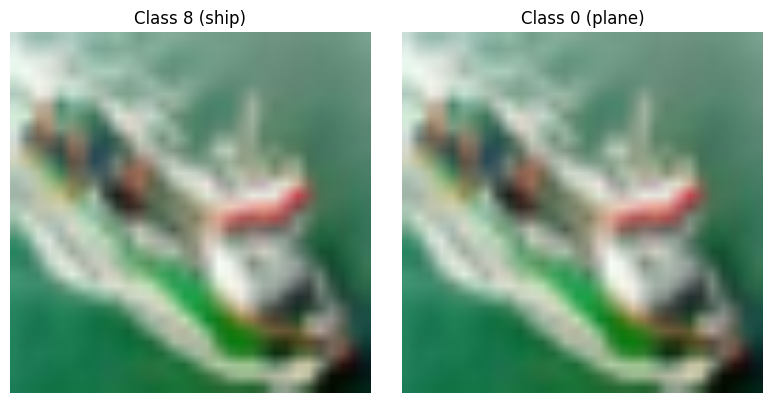

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

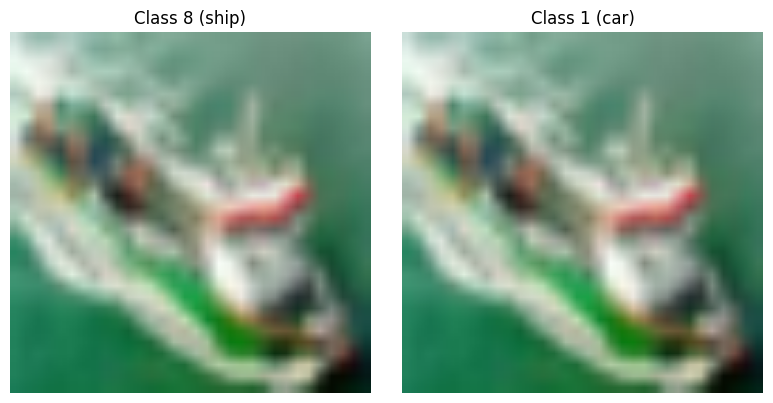

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

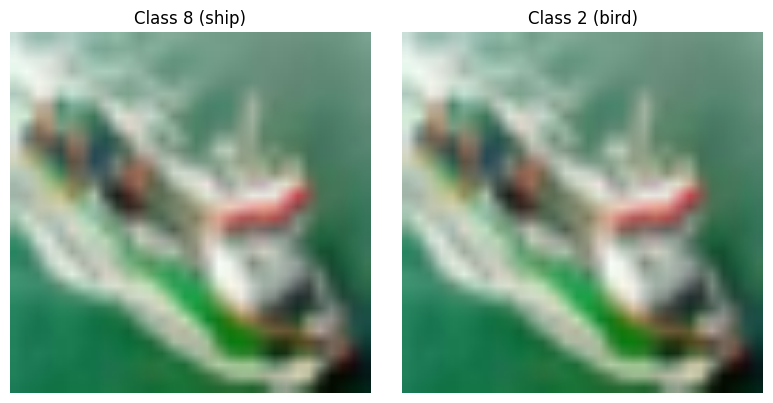

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

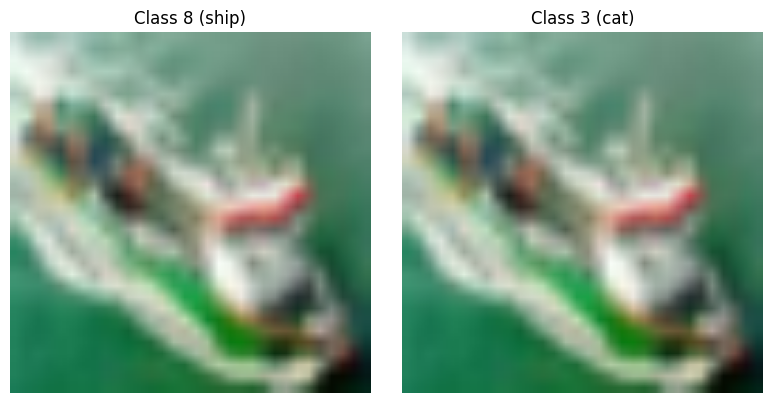

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

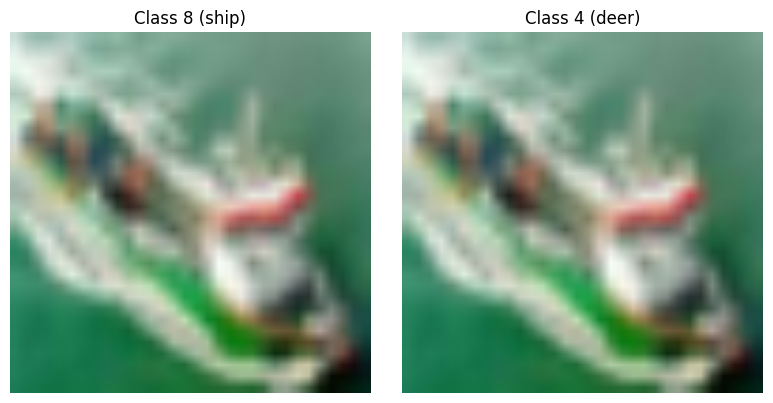

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

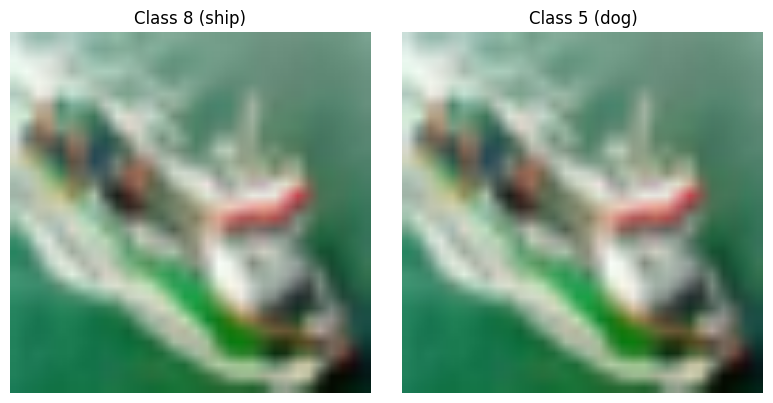

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

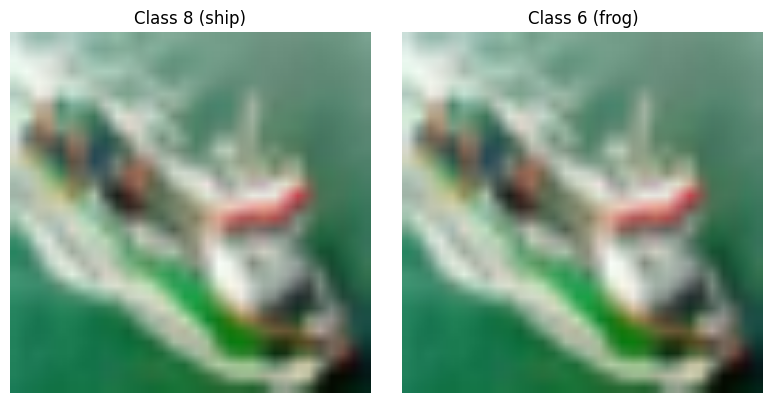

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

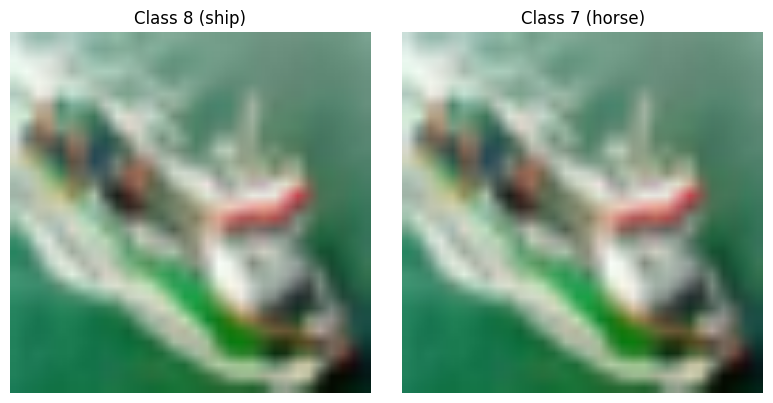

tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         [0.7961, 0.7961, 0.7961,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078],
         [0.1020, 0.1020, 0.1020,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         [0.8745, 0.8745, 0.8745,  ..., 0.6353, 0.6353, 0.6353],
         ...,
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373],
         [0.4824, 0.4824, 0.4824,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.5647],
         [0.8510, 0.8510, 0.8510,  ..., 0.5647, 0.5647, 0.

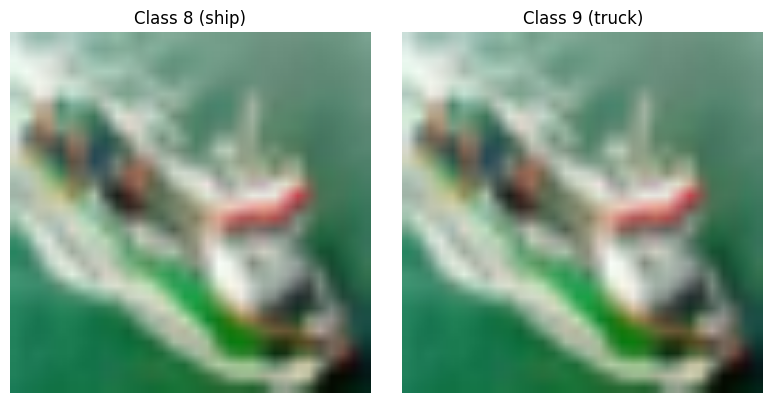

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

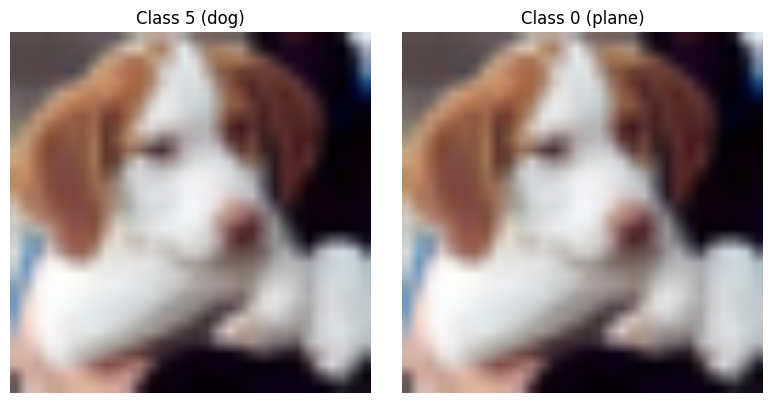

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

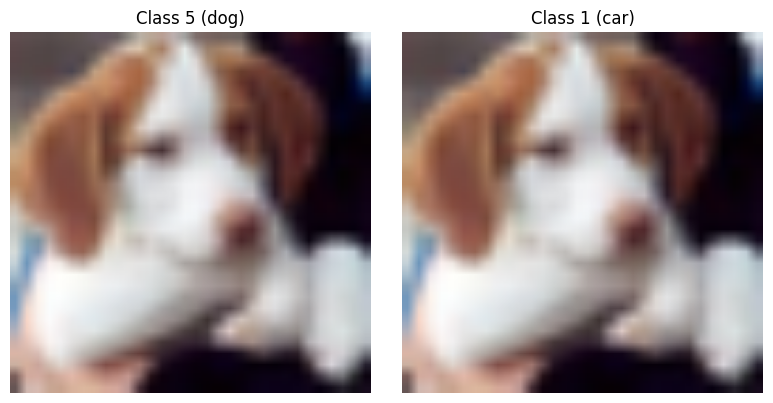

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

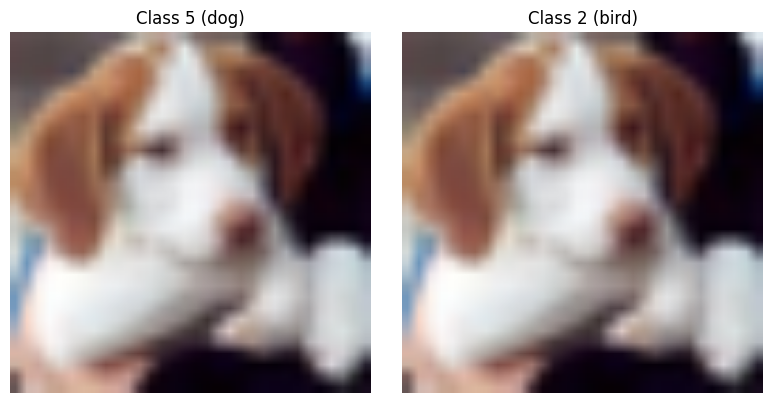

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

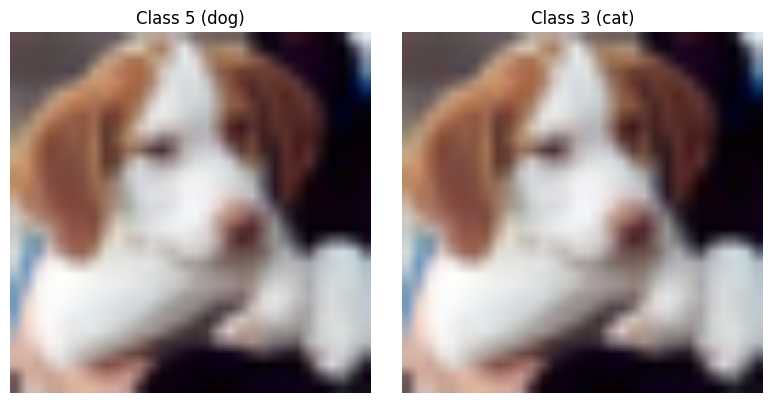

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

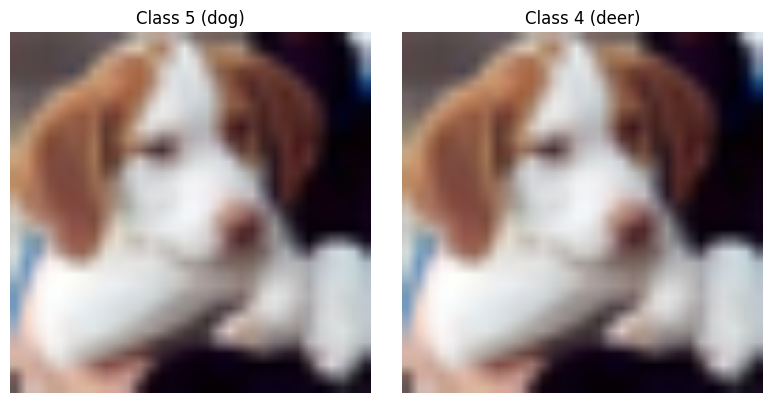

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

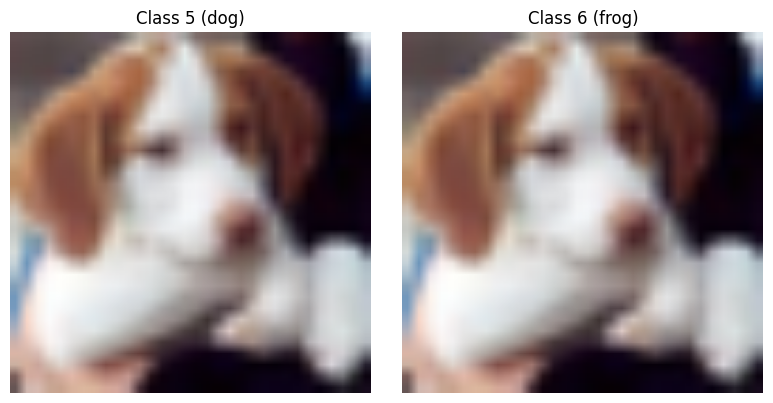

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

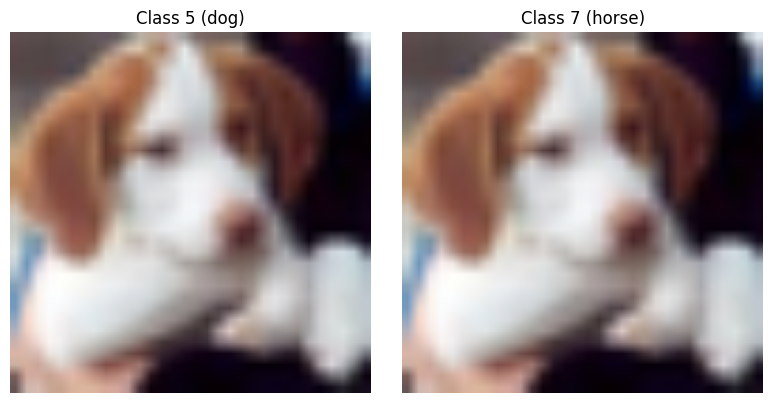

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

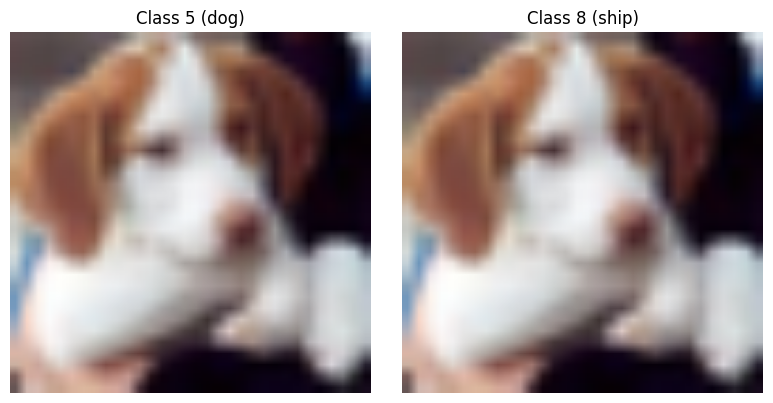

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

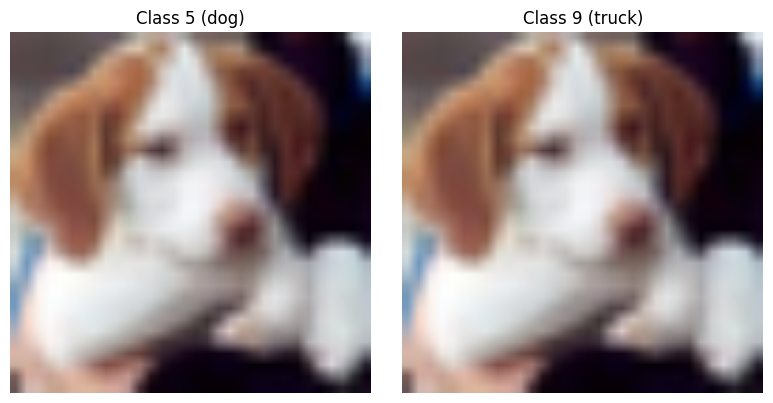

tensor([[[0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         [0.3725, 0.3725, 0.3725,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863],
         [0.4000, 0.4000, 0.4000,  ..., 0.0863, 0.0863, 0.0863]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         [0.2980, 0.2980, 0.2980,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431],
         [0.3333, 0.3333, 0.3333,  ..., 0.0431, 0.0431, 0.0431]],

        [[0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.9412],
         [0.3059, 0.3059, 0.3059,  ..., 0.9412, 0.9412, 0.

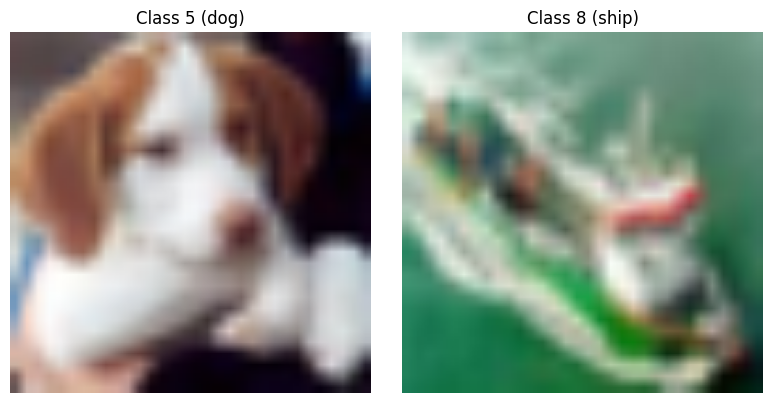

In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
probs = np.load("data/cifar10h-probs.npy")

subset = Subset(dataset, range(15,17))
subset_probs = probs[15:17]

pair_data = PairwiseCIFAR10H(subset, subset_probs)


for x1,l1,x2,l2 in pair_data:
    print(x1,l1,x2,l2)
    visualize_pair(x1, l1, x2, l2, class_names, None, None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


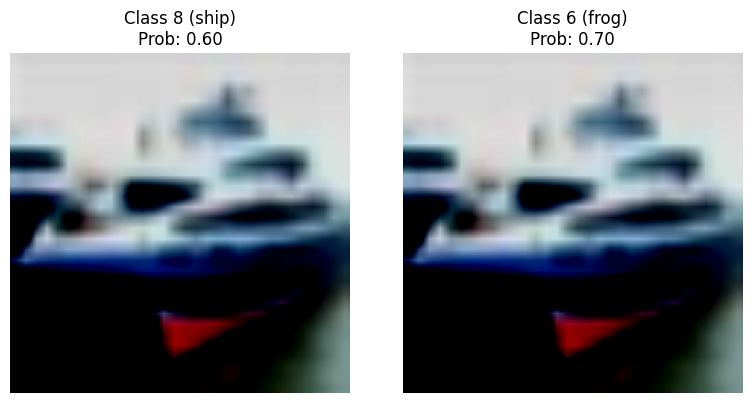

In [42]:
img1, label1, img2, label2 = data[15]
visualize_pair(img1, label1, 0.6, img2, label2, 0.7, class_names=class_names)

In [ ]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

# Training and test data loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
subset = Subset(testset, indices=range(0,5))
pairset = PairwiseCIFAR10H(subset,probs[:5])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
subset_loader = torch.utils.data.DataLoader(dataset=subset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_clf = models.resnet18(pretrained=True)
num_ftrs = model_clf.fc.in_features

model_clf.fc = nn.Linear(num_ftrs, 10)
model_clf = model_clf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clf.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model_clf.train()
    running_loss = 0.0
    for inputs, labels in subset_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_clf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')


Epoch [1/5], Loss: 0.0033
Epoch [2/5], Loss: 0.0001
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


In [ ]:

model_clf.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in subset_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_clf(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 100.00%


In [11]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()


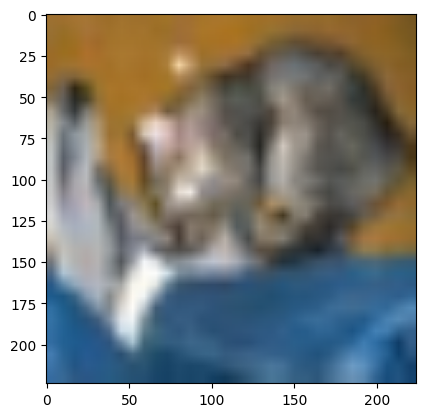

[[4.27141140e-06 8.30981946e-07 8.86487214e-06 2.14739106e-04
  2.08125516e-06 1.37296115e-06 7.50231436e-07 3.08523818e-06
  4.55119989e-05 4.27155010e-06]
 [3.01759087e-06 5.55799318e-07 2.66588881e-06 1.23791915e-05
  9.16261115e-07 8.31544810e-07 2.26292556e-07 2.75525821e-07
  7.39446759e-01 1.44105786e-06]
 [6.48981768e-06 4.02604542e-07 3.84023042e-06 4.18617492e-06
  1.99922101e-06 6.88983732e-07 3.69912897e-07 9.95557230e-07
  2.53979832e-01 1.83943587e-06]
 [1.73522986e-03 1.49001971e-06 5.06606921e-06 1.18661073e-05
  3.83289489e-06 1.86452223e-06 1.81604136e-07 2.29745797e-06
  1.00514553e-05 3.87444925e-06]
 [3.39922644e-06 3.29772411e-06 1.30895796e-05 1.29192586e-06
  9.23008520e-06 4.85014743e-06 4.42415057e-03 2.49458094e-06
  1.67256360e-06 5.41843428e-06]]
true label: cat
predicted label: cat


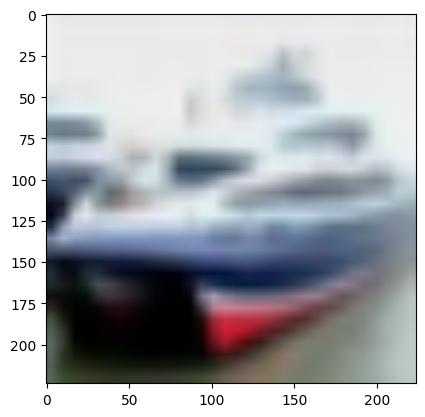

[[4.27141140e-06 8.30981946e-07 8.86487214e-06 2.14739106e-04
  2.08125516e-06 1.37296115e-06 7.50231436e-07 3.08523818e-06
  4.55119989e-05 4.27155010e-06]
 [3.01759087e-06 5.55799318e-07 2.66588881e-06 1.23791915e-05
  9.16261115e-07 8.31544810e-07 2.26292556e-07 2.75525821e-07
  7.39446759e-01 1.44105786e-06]
 [6.48981768e-06 4.02604542e-07 3.84023042e-06 4.18617492e-06
  1.99922101e-06 6.88983732e-07 3.69912897e-07 9.95557230e-07
  2.53979832e-01 1.83943587e-06]
 [1.73522986e-03 1.49001971e-06 5.06606921e-06 1.18661073e-05
  3.83289489e-06 1.86452223e-06 1.81604136e-07 2.29745797e-06
  1.00514553e-05 3.87444925e-06]
 [3.39922644e-06 3.29772411e-06 1.30895796e-05 1.29192586e-06
  9.23008520e-06 4.85014743e-06 4.42415057e-03 2.49458094e-06
  1.67256360e-06 5.41843428e-06]]
true label: ship
predicted label: ship


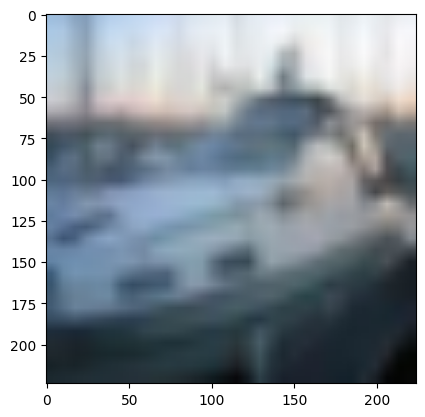

[[4.27141140e-06 8.30981946e-07 8.86487214e-06 2.14739106e-04
  2.08125516e-06 1.37296115e-06 7.50231436e-07 3.08523818e-06
  4.55119989e-05 4.27155010e-06]
 [3.01759087e-06 5.55799318e-07 2.66588881e-06 1.23791915e-05
  9.16261115e-07 8.31544810e-07 2.26292556e-07 2.75525821e-07
  7.39446759e-01 1.44105786e-06]
 [6.48981768e-06 4.02604542e-07 3.84023042e-06 4.18617492e-06
  1.99922101e-06 6.88983732e-07 3.69912897e-07 9.95557230e-07
  2.53979832e-01 1.83943587e-06]
 [1.73522986e-03 1.49001971e-06 5.06606921e-06 1.18661073e-05
  3.83289489e-06 1.86452223e-06 1.81604136e-07 2.29745797e-06
  1.00514553e-05 3.87444925e-06]
 [3.39922644e-06 3.29772411e-06 1.30895796e-05 1.29192586e-06
  9.23008520e-06 4.85014743e-06 4.42415057e-03 2.49458094e-06
  1.67256360e-06 5.41843428e-06]]
true label: ship
predicted label: ship


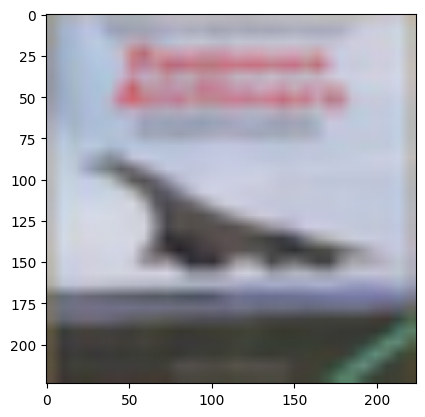

[[4.27141140e-06 8.30981946e-07 8.86487214e-06 2.14739106e-04
  2.08125516e-06 1.37296115e-06 7.50231436e-07 3.08523818e-06
  4.55119989e-05 4.27155010e-06]
 [3.01759087e-06 5.55799318e-07 2.66588881e-06 1.23791915e-05
  9.16261115e-07 8.31544810e-07 2.26292556e-07 2.75525821e-07
  7.39446759e-01 1.44105786e-06]
 [6.48981768e-06 4.02604542e-07 3.84023042e-06 4.18617492e-06
  1.99922101e-06 6.88983732e-07 3.69912897e-07 9.95557230e-07
  2.53979832e-01 1.83943587e-06]
 [1.73522986e-03 1.49001971e-06 5.06606921e-06 1.18661073e-05
  3.83289489e-06 1.86452223e-06 1.81604136e-07 2.29745797e-06
  1.00514553e-05 3.87444925e-06]
 [3.39922644e-06 3.29772411e-06 1.30895796e-05 1.29192586e-06
  9.23008520e-06 4.85014743e-06 4.42415057e-03 2.49458094e-06
  1.67256360e-06 5.41843428e-06]]
true label: plane
predicted label: plane


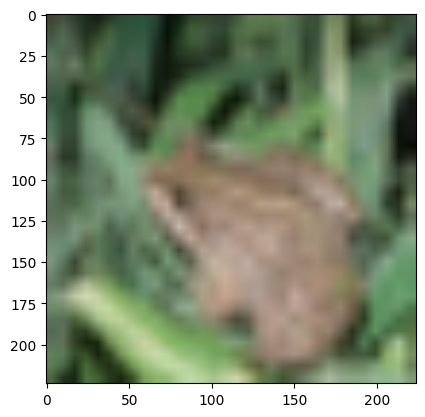

[[4.27141140e-06 8.30981946e-07 8.86487214e-06 2.14739106e-04
  2.08125516e-06 1.37296115e-06 7.50231436e-07 3.08523818e-06
  4.55119989e-05 4.27155010e-06]
 [3.01759087e-06 5.55799318e-07 2.66588881e-06 1.23791915e-05
  9.16261115e-07 8.31544810e-07 2.26292556e-07 2.75525821e-07
  7.39446759e-01 1.44105786e-06]
 [6.48981768e-06 4.02604542e-07 3.84023042e-06 4.18617492e-06
  1.99922101e-06 6.88983732e-07 3.69912897e-07 9.95557230e-07
  2.53979832e-01 1.83943587e-06]
 [1.73522986e-03 1.49001971e-06 5.06606921e-06 1.18661073e-05
  3.83289489e-06 1.86452223e-06 1.81604136e-07 2.29745797e-06
  1.00514553e-05 3.87444925e-06]
 [3.39922644e-06 3.29772411e-06 1.30895796e-05 1.29192586e-06
  9.23008520e-06 4.85014743e-06 4.42415057e-03 2.49458094e-06
  1.67256360e-06 5.41843428e-06]]
true label: frog
predicted label: frog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():

    for image_batch, label_batch in subset_loader:
        outputs = model_clf(image_batch)
        _, predicted = torch.max(outputs, 1)
        for image, label, prediction in zip(image_batch,label_batch, predicted):
            imshow(image)
            print(softmax(outputs.cpu().numpy()))
            print("true label:", class_names[label])
            print("predicted label:", class_names[prediction])


In [1]:
len(cross_instance_pairs)

NameError: name 'cross_instance_pairs' is not defined